[View in Colaboratory](https://colab.research.google.com/github/AmoDinho/Machine-Learning-Crash-Course-with-TF/blob/master/examples/NYC_Taxis.ipynb)

# NYC Taxi Trip Data for 2016

The goal of this study is to try and predict the the total trip amount. We will use Tensorflow to do this. But most importantly we will use linear regression.

# Learning Objectives
* Use the LinearRefressor class in TF tp predict the number the shares based on the number of words in the content.

# Setup


In [2]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Lets load our dataset

In [42]:
df_taxi = pd.read_csv("https://storage.googleapis.com/machinelearning_datasets/tlc_yellow_trips_2016.csv", sep=",")

In [43]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
vendor_id          2000 non-null int64
passenger_count    2000 non-null int64
trip_distance      2000 non-null float64
fare_amount        2000 non-null float64
extra              2000 non-null float64
mta_tax            2000 non-null float64
tip_amount         2000 non-null float64
tolls_amount       2000 non-null float64
imp_surcharge      2000 non-null float64
total_amount       2000 non-null float64
dtypes: float64(8), int64(2)
memory usage: 156.3 KB


In [40]:
df_taxi.describe()

count   2000.0
mean       3.1
std        3.8
min        0.0
25%        0.9
50%        1.7
75%        3.3
max       25.0
Name: trip_distance, dtype: float64

# EDA



*   Check distributions of total_amount,trip_distance, fare_amount and passenger_count
*   check the strenght between relationships.



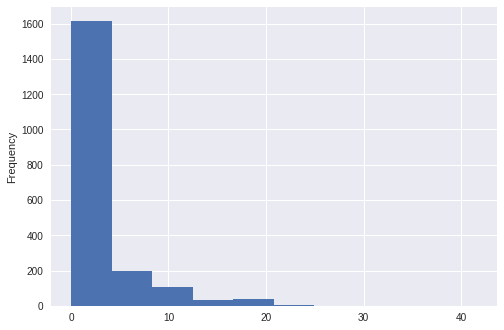

In [0]:
#lets plot some histograms
df_taxi['trip_distance'].plot(kind='hist')

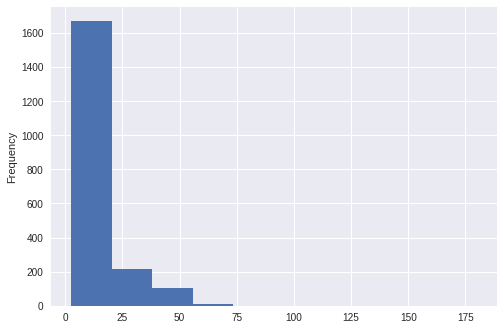

In [0]:
df_taxi['fare_amount'].plot(kind='hist')

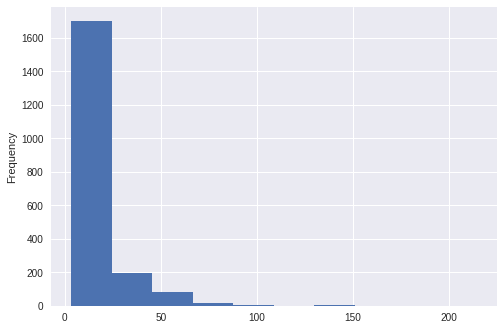

In [0]:
df_taxi['total_amount'].plot(kind='hist')

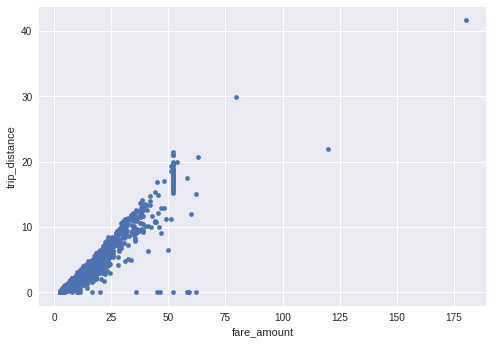

In [0]:
df_taxi.plot(kind='scatter', x='fare_amount',y='trip_distance')
plt.show()

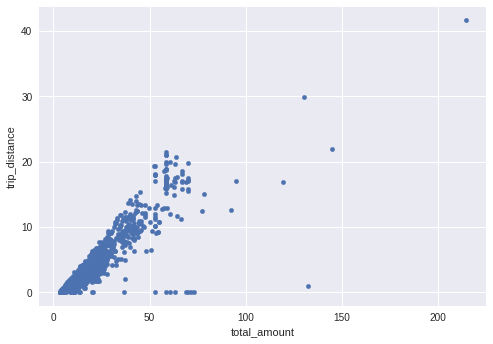

In [0]:
df_taxi.plot(kind='scatter', x='total_amount',y='trip_distance')
plt.show()

In [0]:
#Lets test correlation between variables
corr = df_taxi.corr()

corr

,vendor_id,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount
vendor_id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
passenger_count,nan,1.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
trip_distance,nan,0.0,1.0,0.9,0.2,0.0,0.2,0.6,0.2,0.9
fare_amount,nan,0.0,0.9,1.0,0.1,0.0,0.3,0.5,0.1,1.0
extra,nan,-0.0,0.2,0.1,1.0,-0.0,0.1,0.6,0.8,0.3
mta_tax,nan,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,0.4,0.0
tip_amount,nan,-0.0,0.2,0.3,0.1,0.0,1.0,0.2,0.1,0.5
tolls_amount,nan,0.0,0.6,0.5,0.6,0.0,0.2,1.0,0.6,0.6
imp_surcharge,nan,-0.0,0.2,0.1,0.8,0.4,0.1,0.6,1.0,0.3
total_amount,nan,0.0,0.9,1.0,0.3,0.0,0.5,0.6,0.3,1.0


In [6]:
corr_mat = df_taxi[['trip_distance','total_amount']]

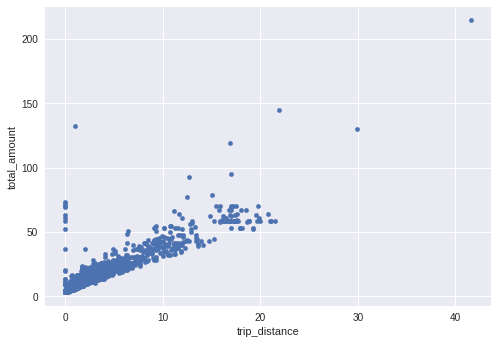

In [10]:
corr_mat.corr()

corr_mat.plot(kind='scatter',x='trip_distance',y='total_amount')

# Data Preprocessing

we need to check if there are missing values in our data set.

In [11]:
#check for null values
df_taxi.notnull().all()

vendor_id          True
passenger_count    True
trip_distance      True
fare_amount        True
extra              True
mta_tax            True
tip_amount         True
tolls_amount       True
imp_surcharge      True
total_amount       True
dtype: bool

# ML Pipeline

In [44]:
#Define input feature
my_feature = df_taxi[["trip_distance"]]

#make a numeric feature column for n_token_content
feature_columns = [tf.feature_column.numeric_column("trip_distance")]

In [45]:
#Define target label
targets = df_taxi["total_amount"]

# Build Linear Regressor

In [46]:
#Using gradient descent as the optimizer for training our model
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# configure the linear reg model with feature cols and optimizer
linear_regressor = tf.estimator.LinearRegressor(
     feature_columns=feature_columns,
     optimizer=my_optimizer
)

# Create Input Function

In [47]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Trains a linear regression model for one feature
         
     Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    #conver pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    #Construct a dataset and config batching/repeating
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    #Shuffle data 
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
      
    #return next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

#Lets try and train the model

In [48]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

## Evaluate the model

In [49]:
#create an input function for predictions
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1,shuffle=False)

#make predictions on the linear regressor
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

#Predictions need to be formatted into an array for metrics
predictions = np.array([item['predictions'][0] for item in predictions])


#Mean squared error and root mean squarded error
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

print("The MSE",mean_squared_error)
print("The RMSE",root_mean_squared_error)

The MSE 485.4977581205849
The RMSE 22.03401366343828


In [50]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,2000.0,2000.0
mean,0.0,16.4
std,0.0,14.8
min,0.0,3.3
25%,0.0,8.3
50%,0.0,11.8
75%,0.0,17.8
max,0.0,214.3


# Tweak Model Parameters

In [51]:
def train_model(learning_rate, steps, batch_size, input_feature="trip_distance"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  periods = 10
  steps_per_period = steps / periods
  
  my_feature = input_feature
  my_feature_data = df_taxi[[my_feature]]
  my_label= "total_amount"
  targets = df_taxi[my_label]
  
  #Create features columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  #Create input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1,shuffle=False)
  
   # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = df_taxi.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print ("Training model...")
  print ("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print ("  period %02d : %0.2f",period, root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data):", root_mean_squared_error)

Training model...
RMSE (on training data):
  period %02d : %0.2f 0 22.01382825386778
  period %02d : %0.2f 1 21.99364917963747
  period %02d : %0.2f 2 21.97343417721831
  period %02d : %0.2f 3 21.953060145031102
  period %02d : %0.2f 4 21.933068097771844
  period %02d : %0.2f 5 21.912909728968916
  period %02d : %0.2f 6 21.89374343575068
  period %02d : %0.2f 7 21.87374255633821
  period %02d : %0.2f 8 21.853165505503906
  period %02d : %0.2f 9 21.83335371083996
Model training finished.


,predictions,targets
count,2000.0,2000.0
mean,0.1,16.4
std,0.2,14.8
min,0.0,3.3
25%,0.1,8.3
50%,0.1,11.8
75%,0.2,17.8
max,1.7,214.3


Final RMSE (on training data): 21.83335371083996


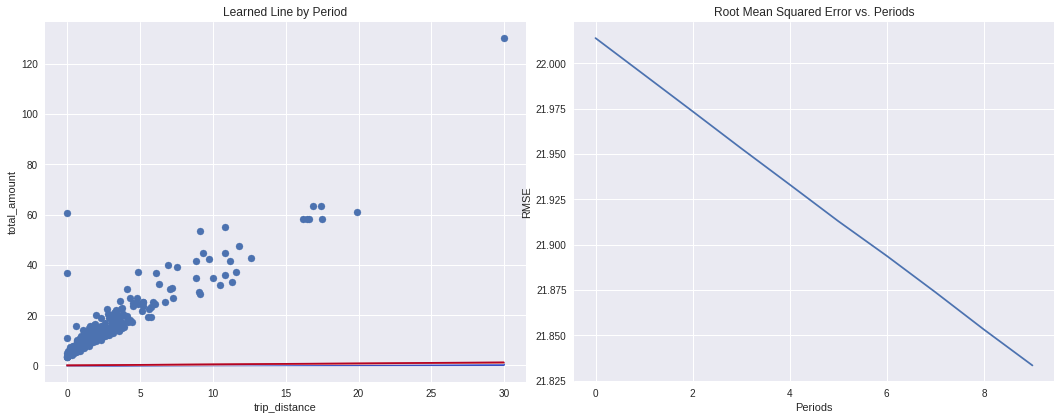

In [52]:

train_model (
    learning_rate=0.00002,
    steps=500,
    batch_size=1
)

In [26]:
min_value = df_taxi["total_amount"].min()
max_value = df_taxi["total_amount"].max()

In [27]:
value = max_value - min_value

In [28]:
value

210.98999999999998

Training model...
RMSE (on training data):
  period %02d : %0.2f 0 21.857441653531033
  period %02d : %0.2f 1 21.680792759795985
  period %02d : %0.2f 2 21.504186207341426
  period %02d : %0.2f 3 21.327644178073406
  period %02d : %0.2f 4 21.151161860001004
  period %02d : %0.2f 5 20.97478476928839
  period %02d : %0.2f 6 20.7984694661769
  period %02d : %0.2f 7 20.622202957369954
  period %02d : %0.2f 8 20.44604921865124
  period %02d : %0.2f 9 20.269944084130874
Model training finished.


,predictions,targets
count,2000.0,2000.0
mean,1.4,16.4
std,1.2,14.8
min,0.3,3.3
25%,0.7,8.3
50%,1.0,11.8
75%,1.5,17.8
max,18.0,214.3


Final RMSE (on training data): 20.269944084130874


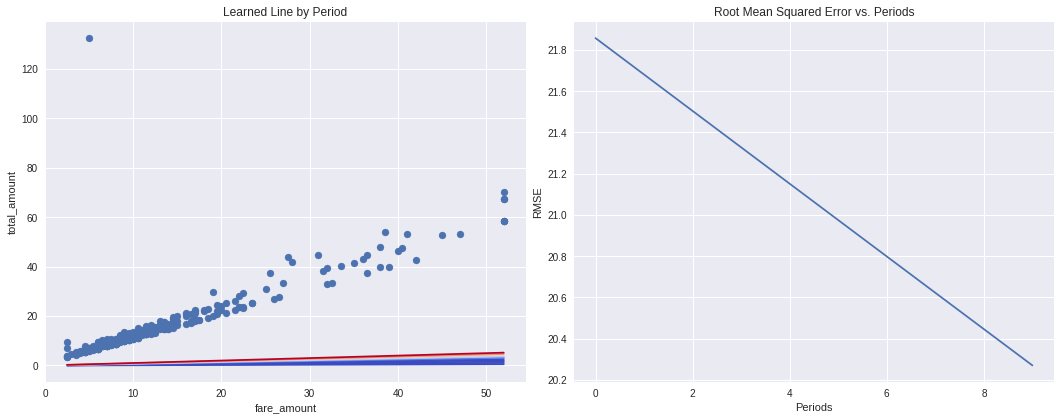

In [29]:
train_model(
learning_rate = 0.00002,
steps=1000,
batch_size=5,
input_feature="fare_amount"
)

In [39]:
train_model(
learning_rate = 0.00002,
steps=1000,
batch_size=5,
input_feature="passenger_count"
)

KeyError: ignored

In [38]:
df_taxi2 = (df_taxi['trip_distance']).apply(lambda x: min(x, 25))

df_taxi2.hist()

KeyError: ignored

In [53]:
df_taxi['trip_distance'] = (df_taxi['trip_distance']).apply(lambda x: min(x, 25))


Training model...
RMSE (on training data):
  period %02d : %0.2f 0 22.01390192507992
  period %02d : %0.2f 1 21.994039601644694
  period %02d : %0.2f 2 21.97324554011976
  period %02d : %0.2f 3 21.95294993763112
  period %02d : %0.2f 4 21.932355742946584
  period %02d : %0.2f 5 21.91392096830447
  period %02d : %0.2f 6 21.894003620340172
  period %02d : %0.2f 7 21.87458966048554
  period %02d : %0.2f 8 21.854208599760444
  period %02d : %0.2f 9 21.834941675544144
Model training finished.


,predictions,targets
count,2000.0,2000.0
mean,0.1,16.4
std,0.2,14.8
min,0.0,3.3
25%,0.1,8.3
50%,0.1,11.8
75%,0.2,17.8
max,1.0,214.3


Final RMSE (on training data): 21.834941675544144


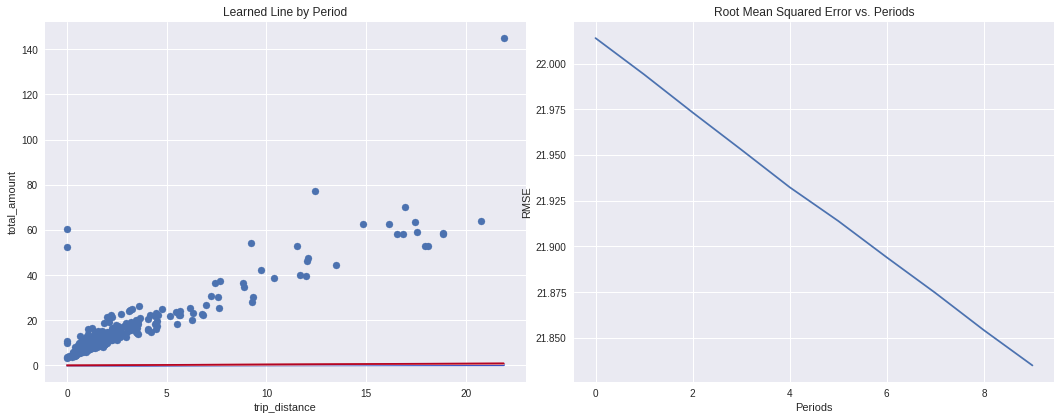

In [54]:

train_model (
    learning_rate=0.00002,
    steps=500,
    batch_size=1
)